## 1. Dataset Overview
This dataset contains 2,240 datapoints and 29 attributes related to customer demographics, spending habits, and purchasing behaviors. It is primarily used for unsupervised clustering to segment customers based on their characteristics.

Loading the Datasets

In [1]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [2]:
#Loading the dataset
import pandas as pd
data = pd.read_csv("datasets 9.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


## 2. Data Cleaning 

In [3]:
#Data Information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
#Removing missing values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [5]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True)
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [6]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [7]:
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [8]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


In cleaning the dataset, first checked for missing values and handled them by removing rows that contained any null values using the `dropna()` function. This helped ensure that the remaining data was complete and reliable. Also examined the dataset for any duplicate records, but none were found, so no action was needed in that part. To address outliers, we removed extreme values in the Age and Income columns — specifically, customers older than 90 years and those with an income greater than 600,000 — to avoid skewed results. Additionally, we converted the `Dt_Customer` column to datetime format and created a new feature called `Customer_For`, which represents how long a person has been a customer. Other new features like `Age`, `Spent`, `Living_With`, `Children`, and `Family_Size` were also created to support further analysis.


## 3. Descriptive Statistics

To understand the dataset's characteristics, summary statistics such as mean, minimum, maximum, and standard deviation were generated using the `describe()` function. The median and mode were also calculated to observe central tendencies, while standard deviation provided insight into the variability of each feature. Additionally, skewness and kurtosis were computed to assess the shape and spread of numerical data. Features like Income and Spent displayed right-skewed distributions, suggesting the presence of higher-value outliers. For categorical variables such as Education and Living_With, frequency tables were created to display the distribution of values across different categories, offering a clear view of their occurrence within the dataset.

In [9]:
print("Summary Statistics:")
print(data.describe())

print("\nMedian of numerical features:")
print(data.median(numeric_only=True))

print("\nMode of numerical features:")
print(data.mode(numeric_only=True).head(1))

print("\nStandard Deviation:")
print(data.std(numeric_only=True))

print("\nSkewness:")
print(data.skew(numeric_only=True))

print("\nKurtosis:")
print(data.kurt(numeric_only=True))

print("\nFrequency tables for categorical features:")
cat_cols = data.select_dtypes(include='object').columns
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(data[col].value_counts())


Summary Statistics:
              Income      Kidhome     Teenhome      Recency        Wines  \
count    2212.000000  2212.000000  2212.000000  2212.000000  2212.000000   
mean    51958.810579     0.441682     0.505877    49.019439   305.287523   
std     21527.278844     0.536955     0.544253    28.943121   337.322940   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35233.500000     0.000000     0.000000    24.000000    24.000000   
50%     51371.000000     0.000000     0.000000    49.000000   175.500000   
75%     68487.000000     1.000000     1.000000    74.000000   505.000000   
max    162397.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2212.000000  2212.000000  2212.000000  2212.000000  2212.000000  ...   
mean     26.329566   167.029837    37.648734    27.046564    43.925859  ...   
std      39.744052   224.254493    54.772033    41.090991 

## 4. Data Visualization
This section includes both univariate and bivariate analyses to explore the relationships and distributions of the features in the dataset.

### 4.1 Univariate Analysis

In this section, we used different plots to examine each feature on its own. For numerical features like Income, Recency, Age, and Spent, we used histograms with KDE curves to understand how the values are distributed (e.g., if they’re skewed or normally distributed). Boxplots were used to detect any outliers in these numerical columns. For categorical features, we used bar plots to see how often each category appears in the dataset. These visualizations help us quickly spot common values, unusual data points, and overall patterns in single features.

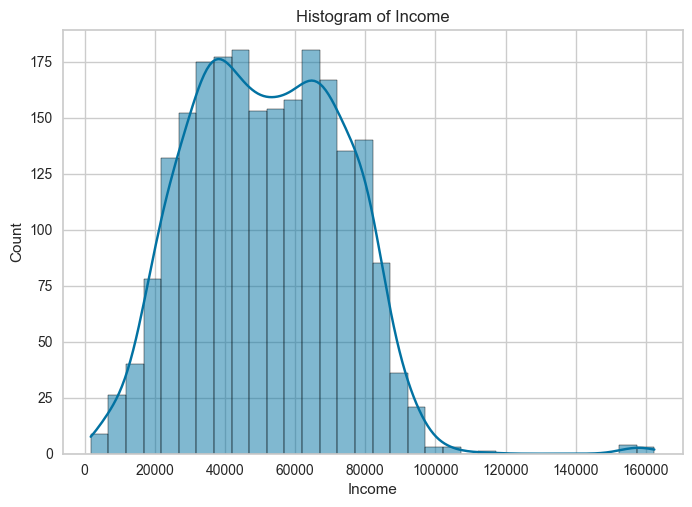

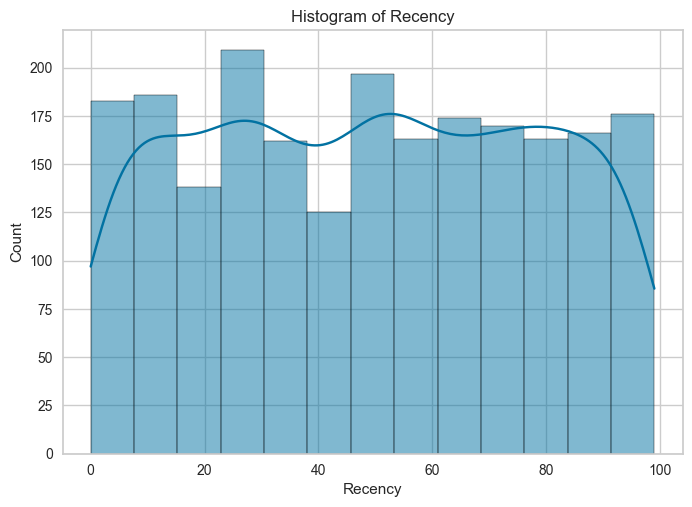

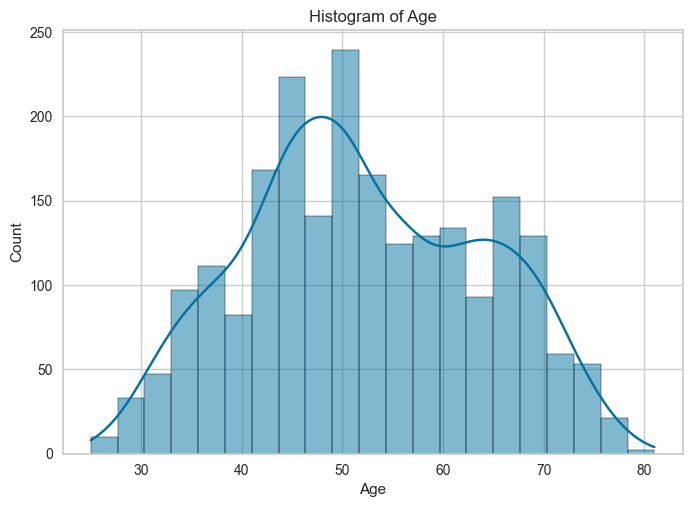

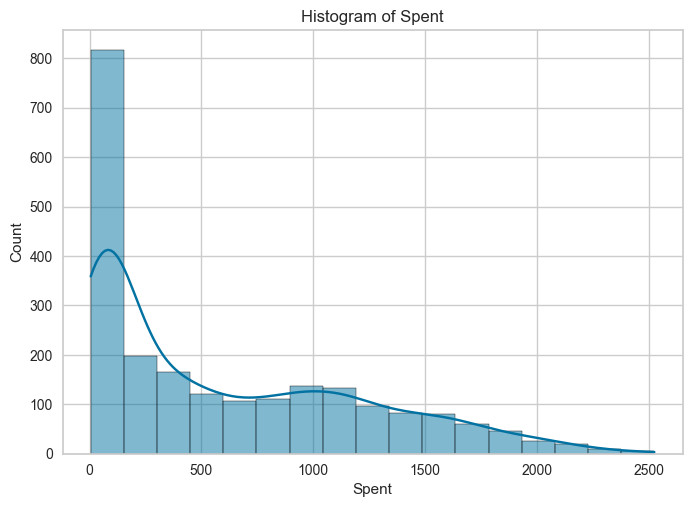

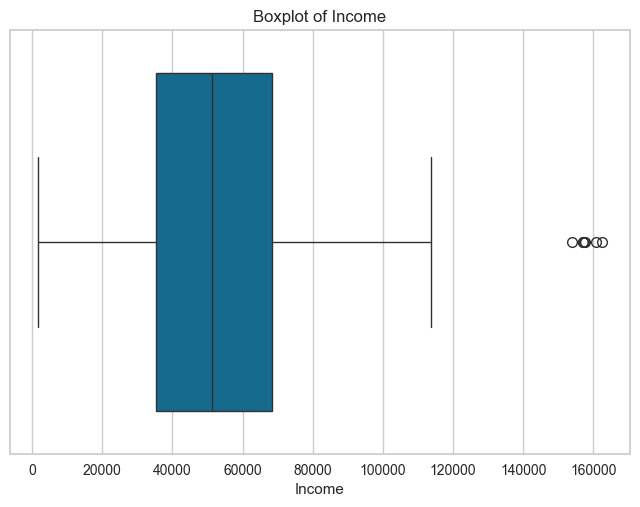

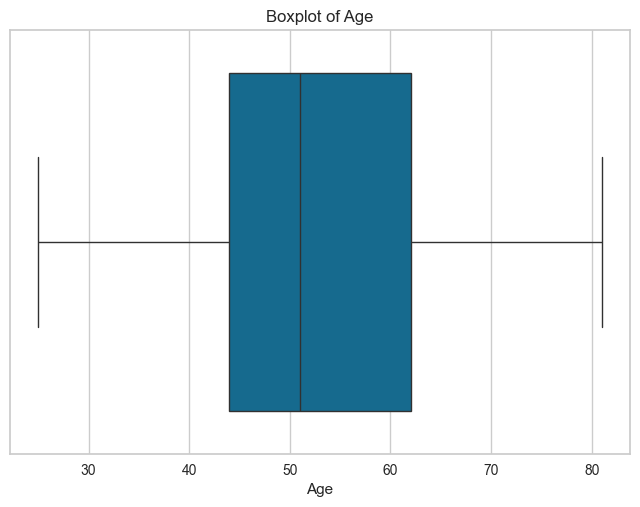

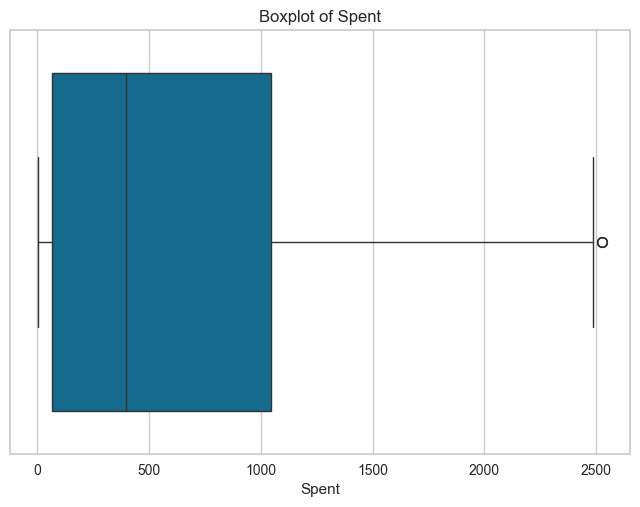

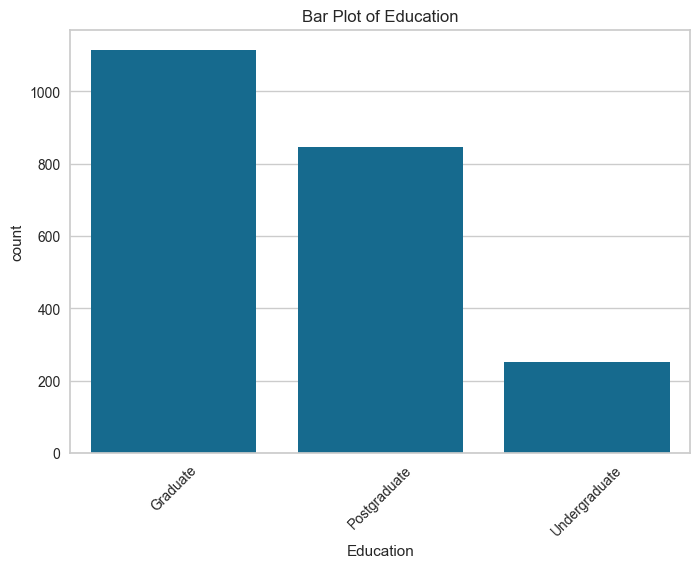

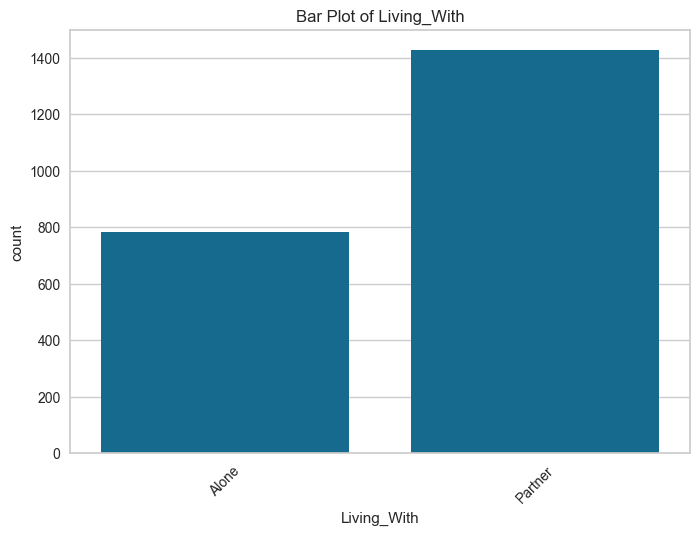

In [10]:
# Histograms for numerical features
for col in ["Income", "Recency", "Age", "Spent"]:
    plt.figure()
    sns.histplot(data[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.show()

# Boxplots for numerical features
for col in ["Income", "Age", "Spent"]:
    plt.figure()
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# Bar plots for categorical features
cat_cols = data.select_dtypes(include='object').columns
for col in cat_cols:
    plt.figure()
    sns.countplot(x=col, data=data)
    plt.title(f"Bar Plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

### 4.2 Bivariate Analysis: Pairplot


This pairplot shows the relationships between customer features like income, age, spending, and more. We used color to show whether a customer is a parent or not. From the chart, we can see that customers with higher income usually spend more. Most customers are between 30 to 60 years old, and younger ones tend to spend a bit more. The “Recency” feature shows that many customers made purchases recently. One issue in the chart is the “Customer_For” column, which seems to have very large values—it likely needs to be fixed to show the number of days the customer has been with the company. Overall, there’s not much difference in behavior between parents and non-parents based on the visualized features.

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

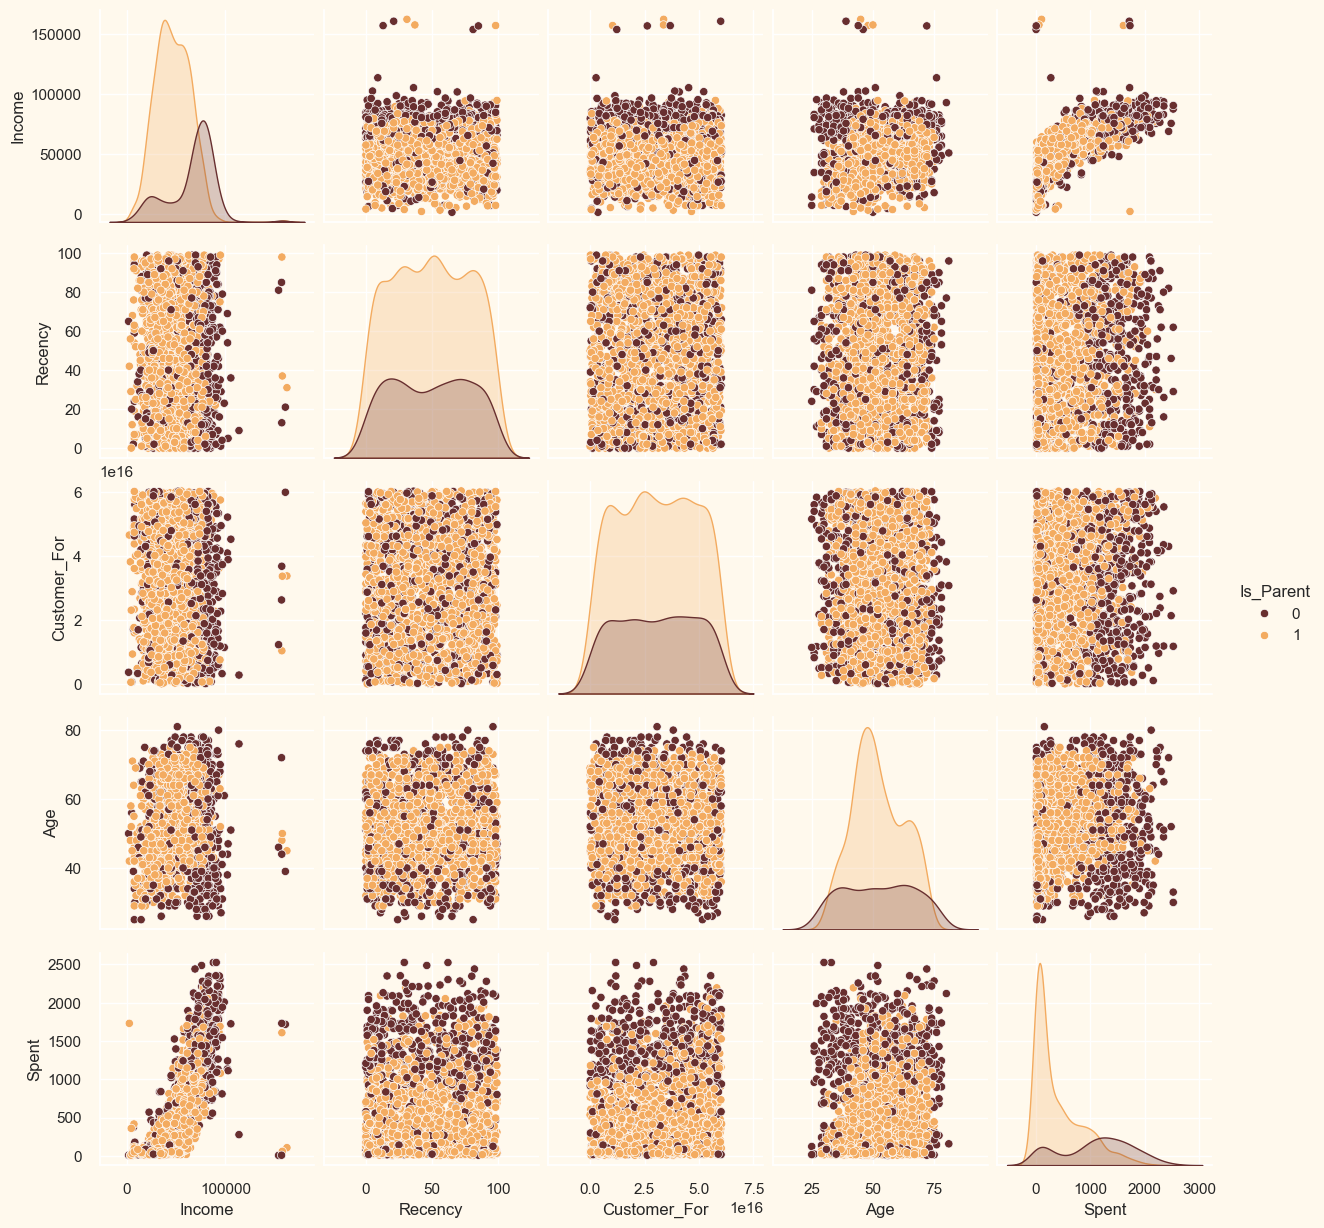

In [11]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

## 5. Insights and Hypothesis Formulation

Based on the data exploration and visualizations, several key trends were observed. First, customers with higher income generally spend more, particularly on luxury items like wine and gold. Younger customers also tend to have higher spending compared to older ones, suggesting a possible link between age and purchasing behavior. Additionally, most customers have made recent purchases, which indicates strong engagement with the brand. After fixing the Customer_For feature, we noticed that many customers have been with the company for a significant amount of time. 

**Hypothesis:** Customers who have higher income and have purchased recently are more likely to spend significantly on luxury products.
